# Introduction
This notebook explores an alternative, non fft-based processing of WAI tests (and potentially calibration). 

The basic idea is that when we do a chirp, we know the center frequency at every time in the signal. So, we can just do a basic Fourier Transform using the sin/cos basis for THAT center frequency. 

There was a question about whether using the chirp as a basis is 'better', so this notebook also explores that question.

Mathematically, given a time signal g(t), solve for the amplitude $A(f)$ in: 

$$f(t) = A(f) e^{i \omega t} = A(f) e^{i2 \pi f t} = A(f) [\cos(2 \pi f t) + i \sin(2 \pi f t)]$$

In [1]:
# Load plot library
%matplotlib inline 

In [2]:
# Dependencies
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from owai.core import signal_processing_utils as spu

In [3]:
# Chirp parameters -- so we have something to test. There's no magic here. 
f0 = 100
f1 = 21000
duration = 6
samplerate = 96000

# This is an arbitrary amplitude function, so we can double-check that we are doing all the match correctly
amplitude = lambda freq: 0.5 + (freq / (f1 * 2))**2
# amplitude = lambda freq: 0.5

# Make the chirp signal -- and it's 90 deg phase-shifted version (potential orthogonal basis)
chirp_times = np.linspace(0, duration, int(samplerate * duration))
chirp, f_at_t = spu.make_chirp(chirp_times, f0, f1, amplitude, return_freq=True)
chirp00 = spu.make_chirp(chirp_times, f0, f1, phi=0)
chirp90 = spu.make_chirp(chirp_times, f0, f1, phi=np.pi/2)

Text(0, 0.5, 'Amplitude (fraction of FS)')

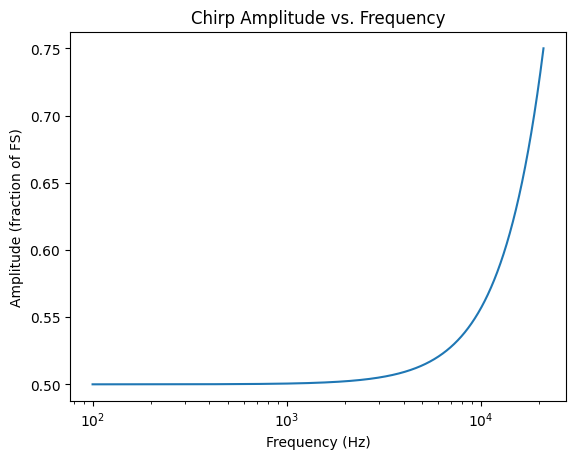

In [4]:
plt.semilogx(f_at_t, amplitude(f_at_t))
plt.title("Chirp Amplitude vs. Frequency")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (fraction of FS)")

Text(0.5, 1.0, 'FFT of Chirp Signal')

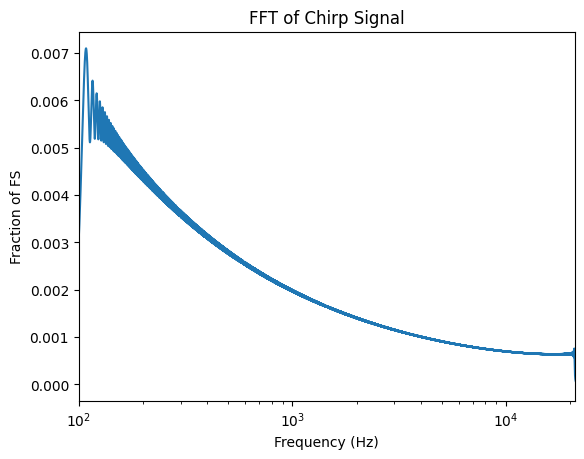

In [5]:
# Compute the reference fourier transform
ref_f, ref_a = spu.to_fourier(chirp, samplerate)

plt.figure()
plt.semilogx(ref_f, np.abs(ref_a))
plt.xlim(f0, f1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fraction of FS")
plt.title("FFT of Chirp Signal")

Text(0, 0.5, 'Fraction of FS')

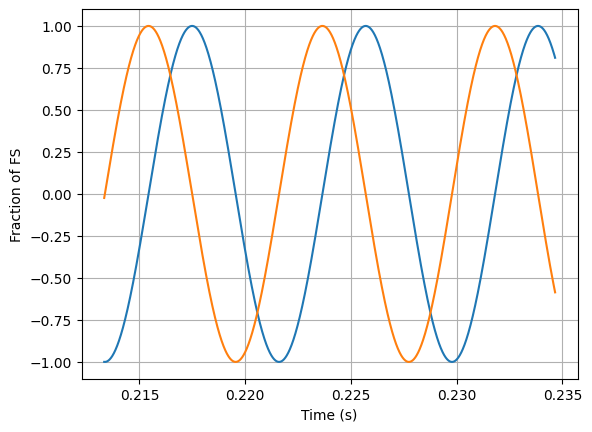

In [6]:
# Compute the DCT-like transform
block_size = 2048
offset = 0
offset = block_size * 10
slc0 = slice(offset, offset+block_size)
plt.figure()
plt.plot(chirp_times[slc0], chirp00[slc0])
plt.plot(chirp_times[slc0], chirp90[slc0])
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Fraction of FS")

# Goal
We want to know the energy contents over the expected frequencies for a segment of the chirp. 
Typically, you would a do a DCT, but we want to see if we can use the chirp as our function instead. 

For use to be able to use the chirp we need TWO functions. The one chirp + an orthogonal chirp (90 deg phase shifted). These need to be orthogonal so that we can get both the amplitude and phase, as needed by our system. 

IN the tests below we check if this is true, discretely. 

In [7]:
def check_orthogonality(s1, s2):
    print("""mean(s1 * s2): \t {}  --> should be 0
mean(s1):        {} --> should be 0
mean(s2):        {} --> should be 0
mean(s1 * s1):   {} --> should be large
mean(s2 * s2):   {} --> should be large""".format((s1 * s2).mean(),s1.mean(), s2.mean(), (s1**2).mean(),(s2**2).mean())
         )

In [8]:
# Check to make sure the two chirps are orthogonal -- NOPE!
check_orthogonality(chirp00[slc0], chirp90[slc0])

mean(s1 * s2): 	 -0.010761878667028036  --> should be 0
mean(s1):        0.0338068776407377 --> should be 0
mean(s2):        0.11060796246610272 --> should be 0
mean(s1 * s1):   0.5152743179849906 --> should be large
mean(s2 * s2):   0.4847256820150093 --> should be large


In [9]:
# Maybe they are orthogonal if we look at a window where the center freqency is periodic? 
f_center = f_at_t[offset + block_size // 2]
# number of samples per waveform
width = np.round(samplerate / f_center)
n = int(block_size // width)
slc = slice(offset + int(block_size // 2 - n / 2 * width), offset + int(block_size // 2 + n / 2 * width))
check_orthogonality(chirp00[slc], chirp90[slc])
# NOT Bad actually!


mean(s1 * s2): 	 0.0001516769961622369  --> should be 0
mean(s1):        0.0010189674266269503 --> should be 0
mean(s2):        -0.000655187811453681 --> should be 0
mean(s1 * s1):   0.500301695134554 --> should be large
mean(s2 * s2):   0.499698304865446 --> should be large


In [10]:
# How about from first zero to last zero
inds = np.argwhere((chirp[slc0] < 0) & (chirp[slc0.start+1:slc0.stop+1] >= 0))
slc = slice(inds[0,0] + offset, inds[-1, 0] + offset)
check_orthogonality(chirp00[slc], chirp90[slc])
# NOPE!

mean(s1 * s2): 	 0.00029081887570078964  --> should be 0
mean(s1):        0.0011624153785850084 --> should be 0
mean(s2):        -3.7419048457848745e-05 --> should be 0
mean(s1 * s1):   0.5000197211769036 --> should be large
mean(s2 * s2):   0.4999802788230964 --> should be large


In [11]:
# Let's try a hanning window
han_win = signal.windows.hann(block_size, sym=True)
check_orthogonality(chirp00[slc0] * han_win, chirp90[slc0])
# NOPE!

mean(s1 * s2): 	 0.00021075609762135836  --> should be 0
mean(s1):        -0.00278423616314058 --> should be 0
mean(s2):        0.11060796246610272 --> should be 0
mean(s1 * s1):   0.1874449142147065 --> should be large
mean(s2 * s2):   0.4847256820150093 --> should be large


mean(s1 * s2): 	 -8.487690247353249e-07  --> should be 0
mean(s1):        -1.0913574190204443e-06 --> should be 0
mean(s2):        1.3501988090995666e-06 --> should be 0
mean(s1 * s1):   0.49999981798999815 --> should be large
mean(s2 * s2):   0.5000001820100018 --> should be large


Text(0, 0.5, 'Fraction of FS')

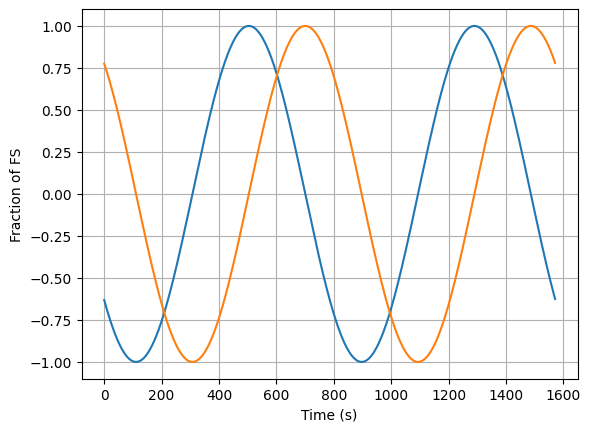

In [12]:
# Now let's try a pure tone near the center frequency that aligns with the samplerate
f_center = f_at_t[offset + block_size // 2]
# number of samples per waveform
width = np.round(samplerate / f_center)
f_discrete = samplerate / width
n = int(block_size // width)
slc = slice(offset + int(block_size // 2 - n / 2 * width), int(offset + block_size // 2 + n / 2 * width))
check_orthogonality(
    np.cos(2 * np.pi * f_discrete * chirp_times[slc]),
    np.sin(2 * np.pi * f_discrete * chirp_times[slc]))
plt.plot(np.cos(2 * np.pi * f_discrete * chirp_times[slc]))
plt.plot(np.sin(2 * np.pi * f_discrete * chirp_times[slc]))
plt.grid(True)
plt.xlabel("Time (s)")
plt.ylabel("Fraction of FS")

In [13]:
# Cool. Let's do a pure-tone DCT for the whole signal
def calc_dct(signal_size=1, frequency="discrete", block_size=block_size, n_sample_offset=0):
    dct_f = []
    dct_a = [] 
    dct_a_chirp = [] 
    n_blck = chirp_times.size / block_size  # This is the number of blocks in the signal
    centers = np.linspace(0, n_blck-1, 256)  # Arbitrarily doing 256 segments (potentially overlapping or not, depends if n_blck < or > 256)
    for i in centers:
        # This is the center index in the time signal
        center_ind = int(np.round(i * block_size + block_size // 2))
        
        # Our Chirp parameters give us the expected frequency at this location in the time series
        f_center = f_at_t[center_ind]
    
        # HOwever, because of the samplerate, the discrete signal does not "exactly" support this frequency
        # so we compute the discrete frequency supported instead
        width = np.round(samplerate / f_center)
        f_discrete = samplerate / width 
        if frequency == "continuous":
            f_discrete = f_center # <-- debugging
    
        # The discrete frequency probably doesn't have the same center index as the continuous one... so shift the center
        center_ind0 = np.argmin(np.abs(f_at_t - f_discrete))
        if center_ind0 != center_ind:
            # print(f_center, f_discrete, center_ind0, center_ind, center_ind0 - center_ind) # <-- debugging
            center_ind = center_ind0

        if signal_size == "largest":
            n = int(block_size // width)  # We could pick the number of wavelength that fit in the block size
        else:
            n = signal_size
    
        # Compute the slices in the time signal around this center
        slc1 = slice(
            center_ind - int(n / 2 * width),
            center_ind + int(n / 2 * width + width % 2)  # The " % 2 " is for odd vs even number of samples
        )
        slc1_off = slice(
            n_sample_offset + center_ind - int(n / 2 * width),
            n_sample_offset + center_ind + int(n / 2 * width + width % 2)  # The " % 2 " is for odd vs even number of samples
        )
        if slc1_off.stop >= chirp.size:
            slc1_off = slice(
                -n_sample_offset + center_ind - int(n / 2 * width),
                -n_sample_offset + center_ind + int(n / 2 * width + width % 2)  # The " % 2 " is for odd vs even number of samples
            )
            
        
        # fraction = (samplerate / f_center) / width  # <-- debugging -- attempt to scale based on actual vs. expected width for center frequency
        norm = 2 #* fraction
    
        # Compute the real and imaginary components of the amplitude using pure tones
        real = np.mean(np.cos(2 * np.pi * f_discrete * chirp_times[slc1]) * chirp[slc1_off]) 
        imag = np.mean(np.sin(2 * np.pi * f_discrete * chirp_times[slc1]) * chirp[slc1_off])
        # ... and using the chirp segments
        real_chirp = np.mean(chirp00[slc1] * chirp[slc1_off]) 
        imag_chirp = np.mean(chirp90[slc1] * chirp[slc1_off])
        dct_f.append(f_discrete)
        dct_a.append(norm*(real - 1j * imag))
        dct_a_chirp.append(norm*(real_chirp - 1j * imag_chirp))
    dct_f = np.array(dct_f)
    dct_a = np.array(dct_a)
    dct_a_chirp = np.array(dct_a_chirp)
    return dct_f, dct_a, dct_a_chirp


What is the correct scaling on the FFT for each frequency? 

The FFT assumes that the signal is periodic -- so the energy depends on the DURATION of how long each frequency is present in the signal. To figure that out depends on the specifics of the logarithmic chirp we're using...

We want to know the change in time over the change in f:

$f = f0 \cdot (f1/f0)^{t / T}$ <-- This is the frequency change for the logarithmic chirp.

solve for t
\begin{align}
\ln (f / f0) &= t/T \ln(f1/f0)\\
\ln (f) -\ln(f0) &= t/T (\ln(f1) - ln(f0)) \\
t  &= T \frac{(\ln (f) -\ln(f0))}{(\ln(f1) - ln(f0))}  \\
\frac{dt}{df} &= \frac{1}{f} \frac{T}{\ln(f1) - ln(f0)} \\
\end{align}




/tmp/ipykernel_29382/3689911396.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.semilogx(ref_f, np.abs(ref_a) * np.sqrt(2) / np.sqrt(duration / ref_f / (np.log(f1) - np.log(f0))) * duration, label="FFT", alpha=0.9)


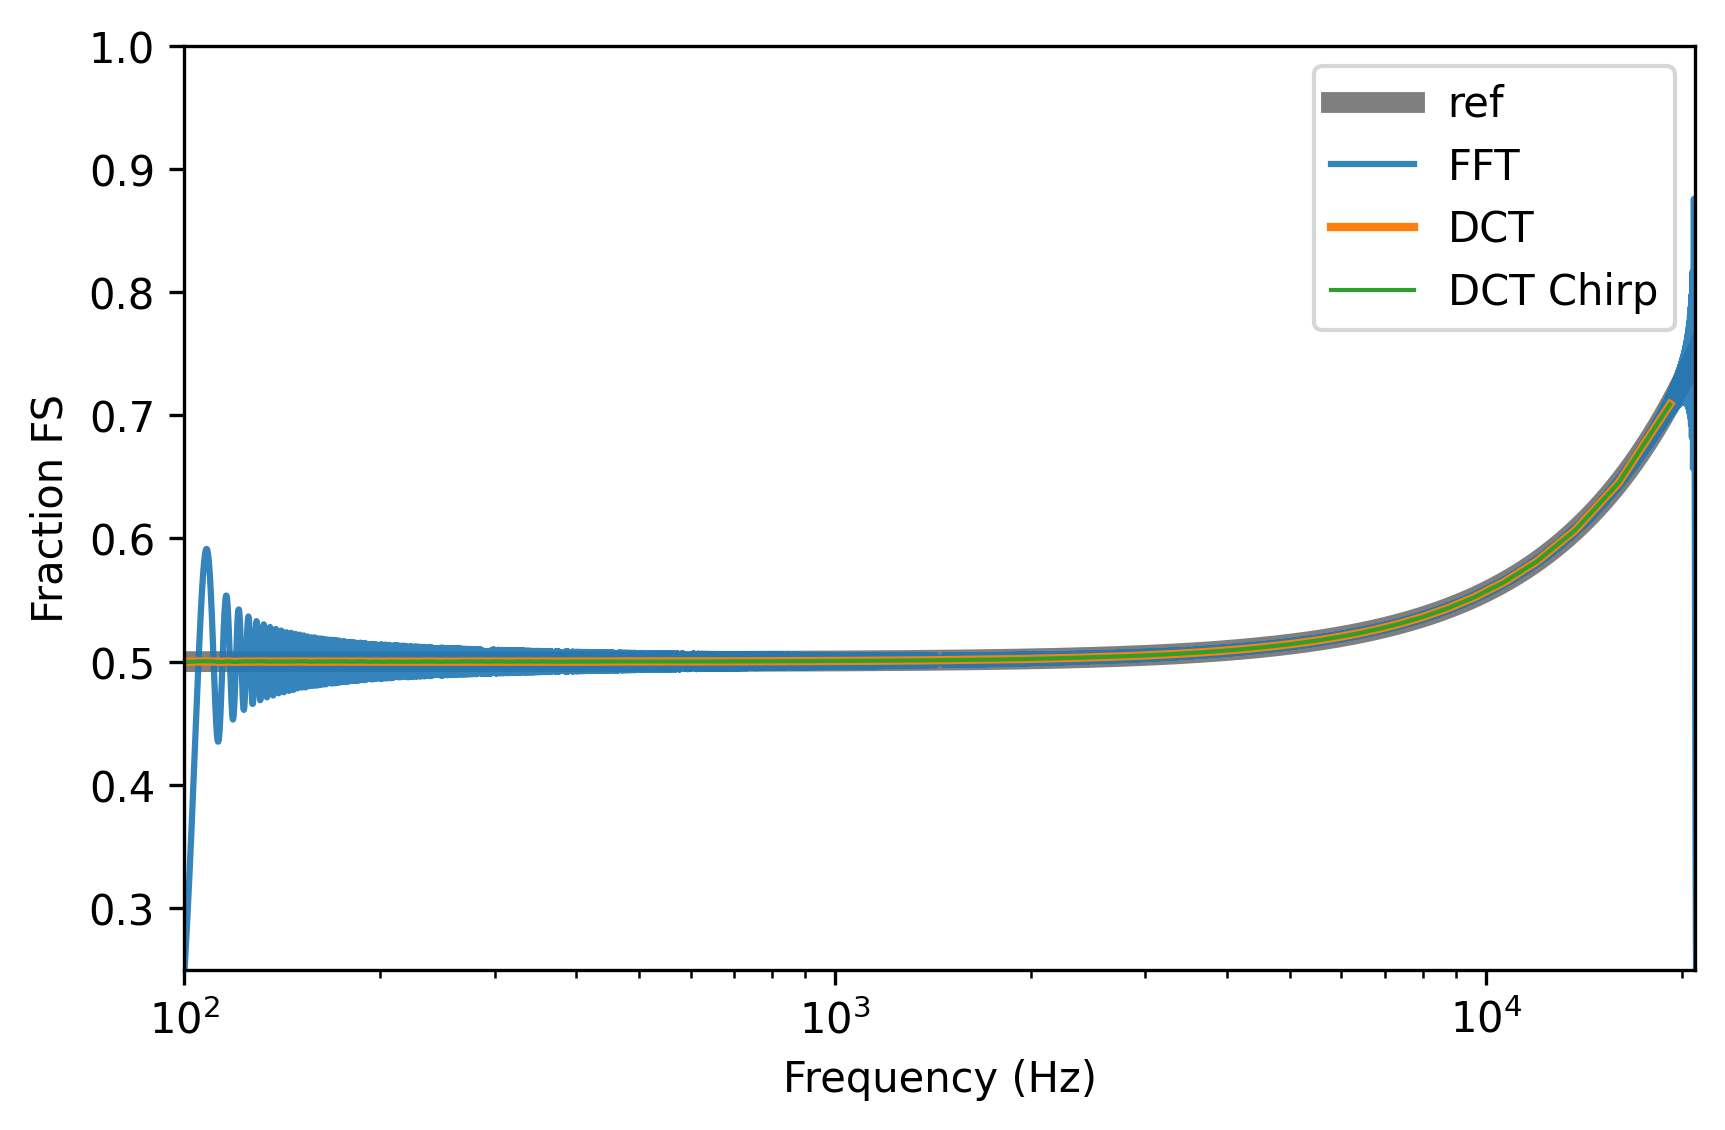

In [14]:
dct_f, dct_a, dct_a_chirp = calc_dct(signal_size=1, frequency="discrete")

plt.figure(figsize=(6.5,4), dpi=300)
plt.semilogx(ref_f, amplitude(ref_f), 'k', label="ref", lw=5, alpha=0.5)
plt.semilogx(ref_f, np.abs(ref_a) * np.sqrt(2) / np.sqrt(duration / ref_f / (np.log(f1) - np.log(f0))) * duration, label="FFT", alpha=0.9)
plt.semilogx(dct_f, np.abs(dct_a), label="DCT", lw=2)
plt.semilogx(dct_f, np.abs(dct_a_chirp), label="DCT Chirp", lw=1)
plt.xlim(f0, f1)
plt.ylim(0.25, 1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fraction FS")
plt.legend()

/tmp/ipykernel_29382/1140720521.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.semilogx(ref_f, np.abs(ref_a) * np.sqrt(2) / np.sqrt(duration / ref_f / (np.log(f1) - np.log(f0))) * duration, label="FFT", alpha=0.9)


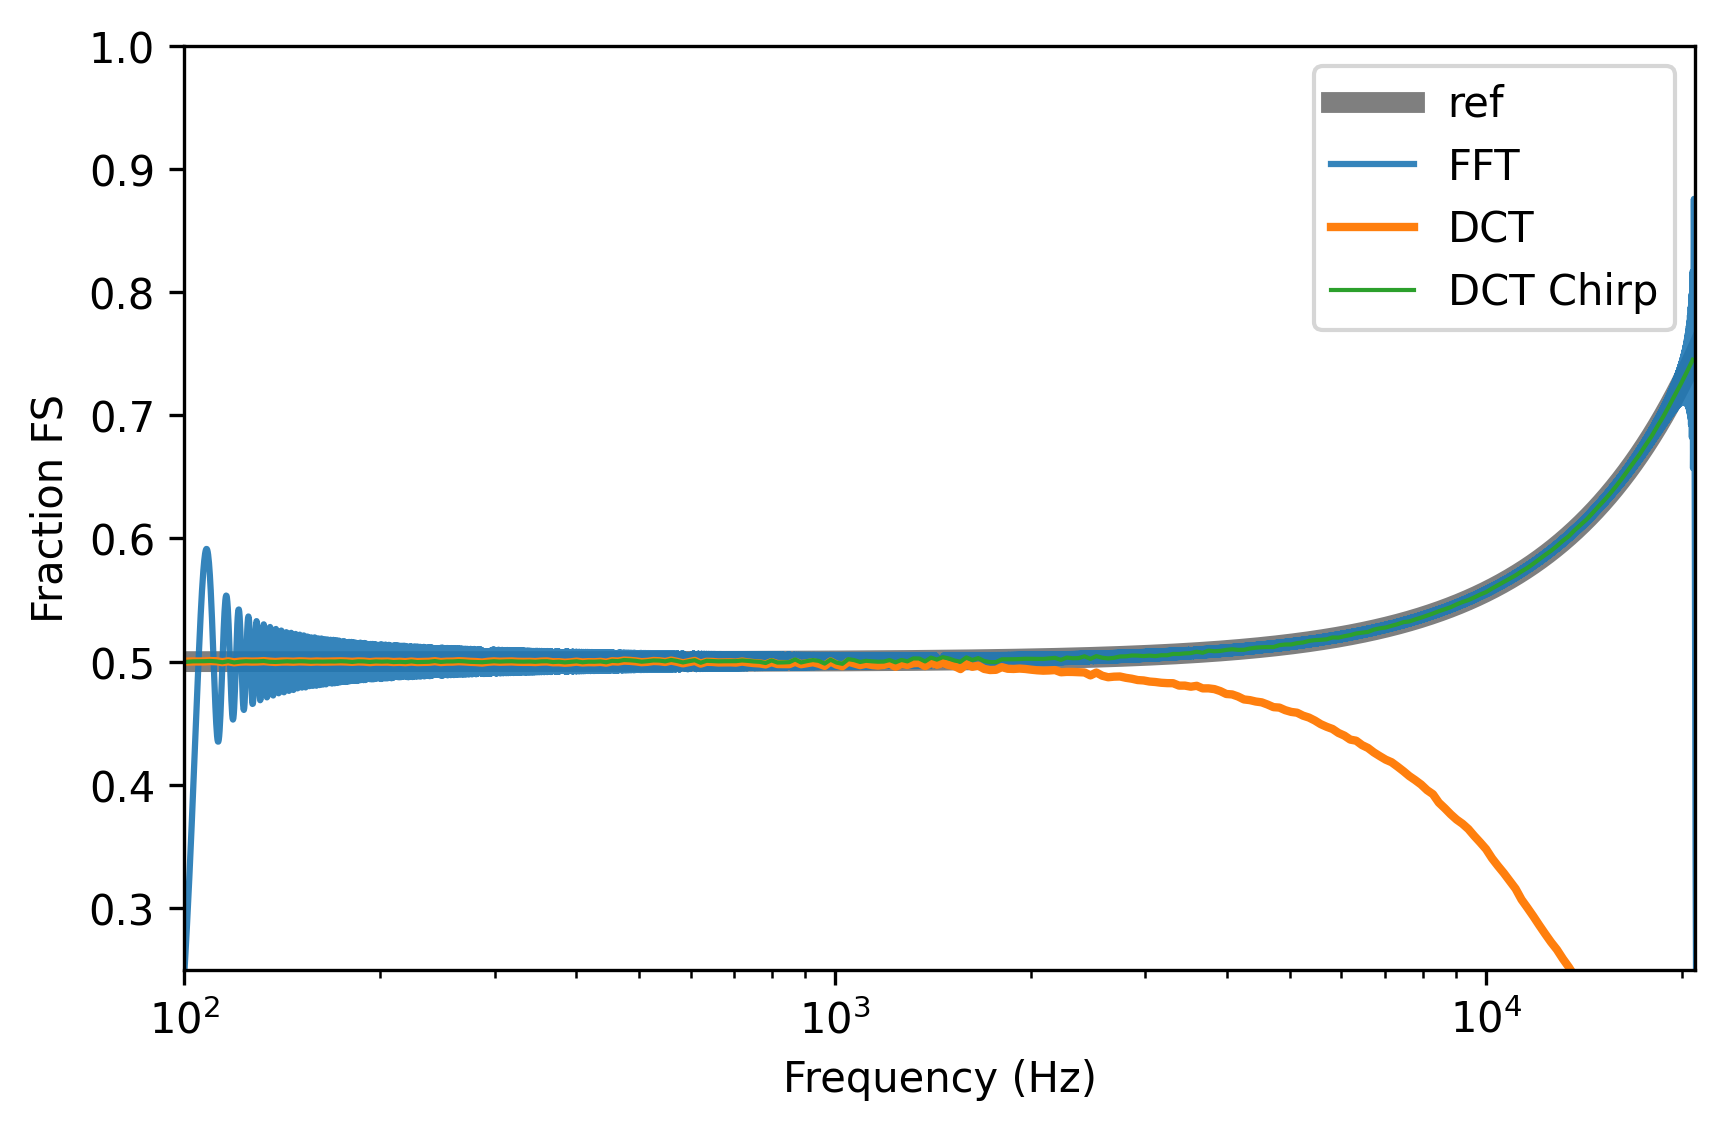

In [15]:
dct_f, dct_a, dct_a_chirp = calc_dct(signal_size="largest", frequency="continuous")

plt.figure(figsize=(6.5,4), dpi=300)
plt.semilogx(ref_f, amplitude(ref_f), 'k', label="ref", lw=5, alpha=0.5)
plt.semilogx(ref_f, np.abs(ref_a) * np.sqrt(2) / np.sqrt(duration / ref_f / (np.log(f1) - np.log(f0))) * duration, label="FFT", alpha=0.9)
plt.semilogx(dct_f, np.abs(dct_a), label="DCT", lw=2)
plt.semilogx(dct_f, np.abs(dct_a_chirp), label="DCT Chirp", lw=1)
plt.xlim(f0, f1)
plt.ylim(0.25, 1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fraction FS")
plt.legend()

## Effect of delay
CAB wanted to know the effect of a phase shift between the chirp basis and the signal. This section explores that. 

First question, how many samples' phase shift should we expect? 

Assume a 3cm (=0.03m) ear canal length, and a there-and-back delay (==0.06m), then
n_samples = 0.06m / (343m/s) * 96000samples/s = 


In [16]:
0.06 / 343 * 96000  # number of samples of delay

16.793002915451897

In [17]:
dct_fs = []
dct_a_chirps = []
offsets = [0, 1, 2, 4, 8, 16]
for offset in offsets:
    dct_f, _, dct_a_chirp = calc_dct(signal_size="largest", frequency="continuous", n_sample_offset=offset)
    dct_fs.append(dct_f)
    dct_a_chirps.append(dct_a_chirp)
dct_fs = np.array(dct_fs)
dct_a_chirps = np.array(dct_a_chirps)
dct_a_chirps.shape

(6, 256)

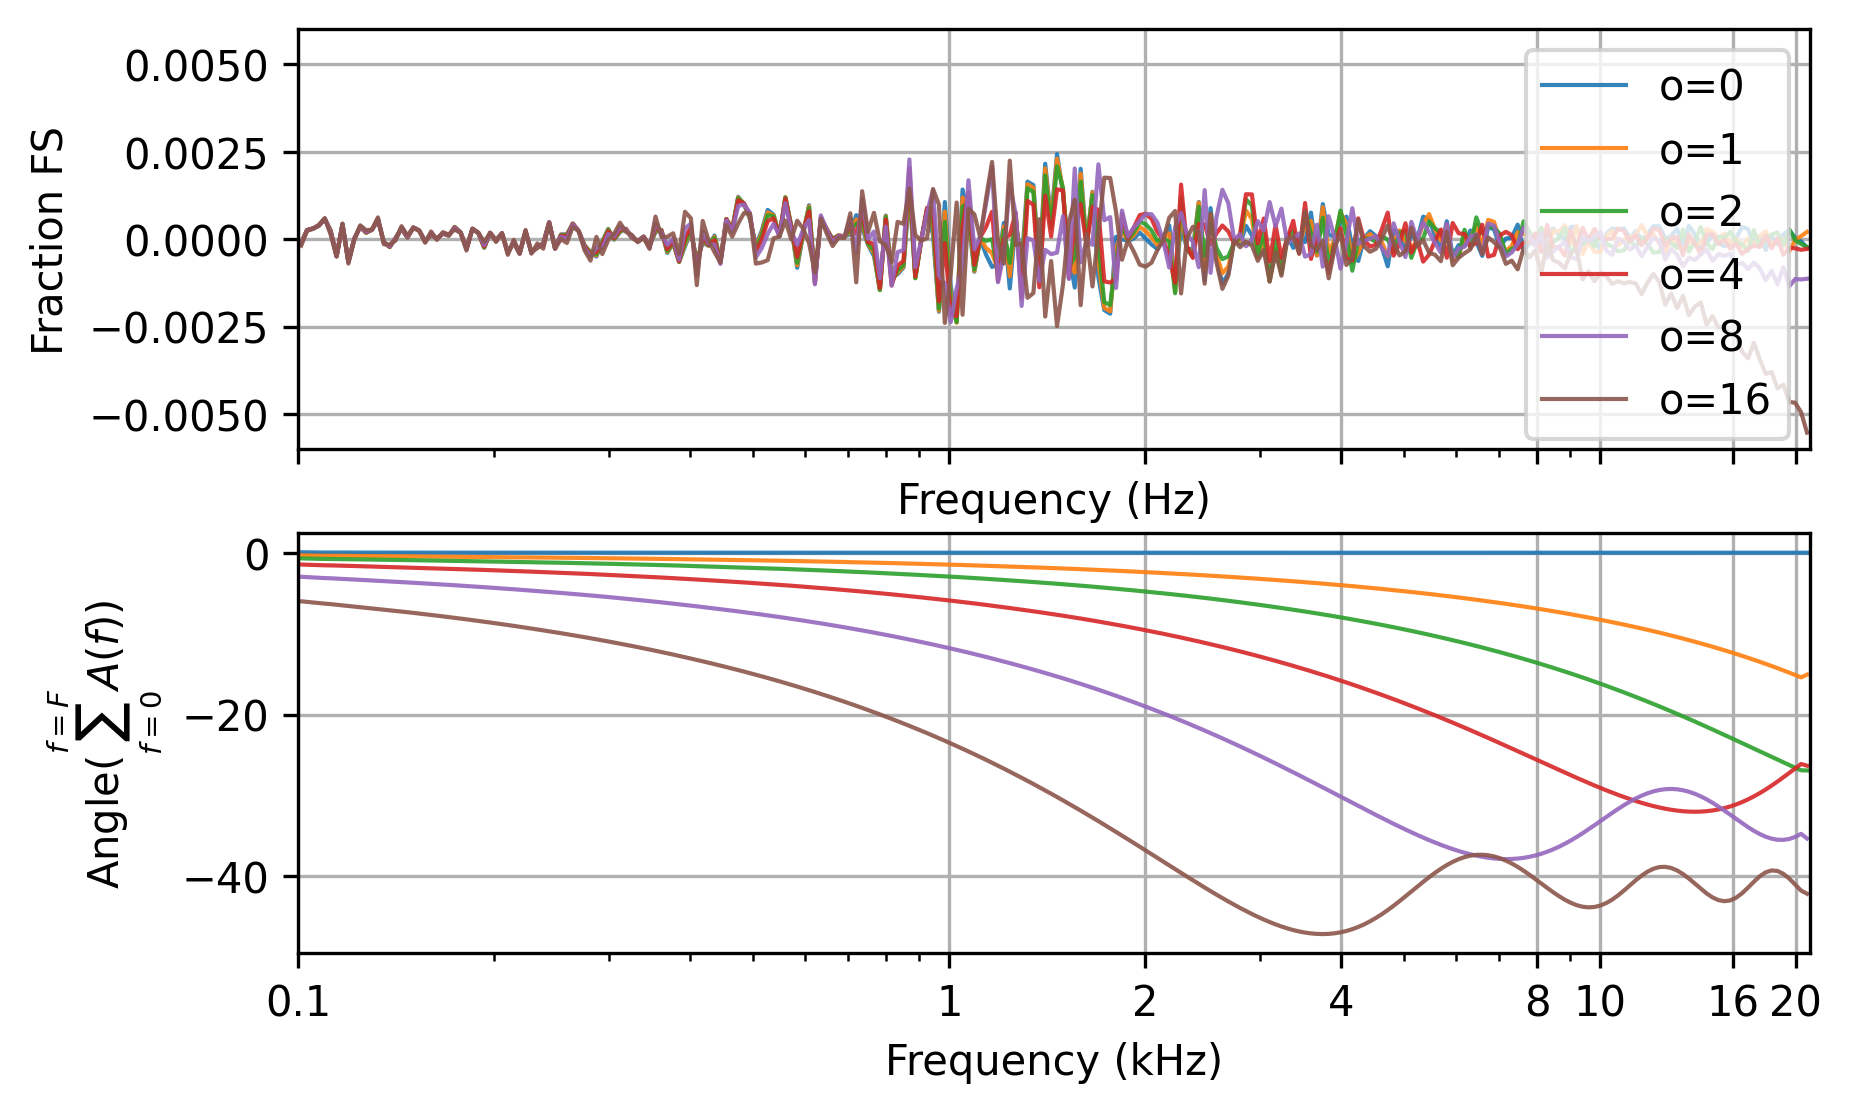

In [18]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6.5,4), dpi=300)
# axs[0].semilogx(ref_f, amplitude(ref_f)*0, 'k', label="ref", lw=1, alpha=1)
axs[0].semilogx(dct_fs.T/1000, np.abs(dct_a_chirps).T - amplitude(dct_fs).T, lw=1, alpha=0.9)
# axs[0].set_xlim(f0, f1)
axs[0].set_ylim(-0.006, 0.006)
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Fraction FS")
axs[0].legend(["o=%d"%offset for offset in offsets])
axs[0].grid()

# axs[1].semilogx(ref_f, 0*amplitude(ref_f), 'k', label="ref", lw=1, alpha=1)
axs[1].semilogx(dct_fs.T/1000, np.rad2deg(np.angle(np.cumsum(dct_a_chirps, axis=-1))).T, lw=1, alpha=0.9)
axs[1].set_xlim(f0/1000, f1/1000)
axs[1].set_xticks([0.1, 1, 2, 4, 8, 10, 16, 20], [0.1, 1, 2, 4, 8, 10, 16, 20])
# axs[0].set_ylim(0.25, 1)
axs[1].set_xlabel("Frequency (kHz)")
axs[1].set_ylabel(r"Angle($\sum_{f=0}^{f=F} A(f)$)")
axs[1].grid()
# axs[1].legend(["ref"] + ["o=%d"%offset for offset in offsets])

# Conclusions
The pure sin/cos version works great if you only look at 1 wavelength. When you look over the whole block, though, the Chirp basis works a lot better. Because of noise in real life situations, the chirp-based approach is probably better -- just as CAB suspected. 